In [ ]:
!pip install  keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras_tuner import RandomSearch, HyperModel

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Generate data paths with labels
train_data_dir = "/content/drive/MyDrive/archive (3)/Training"
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/content/drive/MyDrive/archive (3)/Training/no...,notumor
1,/content/drive/MyDrive/archive (3)/Training/no...,notumor
2,/content/drive/MyDrive/archive (3)/Training/no...,notumor
3,/content/drive/MyDrive/archive (3)/Training/no...,notumor
4,/content/drive/MyDrive/archive (3)/Training/no...,notumor
...,...,...
5707,/content/drive/MyDrive/archive (3)/Training/gl...,glioma
5708,/content/drive/MyDrive/archive (3)/Training/gl...,glioma
5709,/content/drive/MyDrive/archive (3)/Training/gl...,glioma
5710,/content/drive/MyDrive/archive (3)/Training/gl...,glioma


In [ ]:
# Generate data paths with labels
train_data_dir = "/content/drive/MyDrive/archive (3)/Testing"
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
ts_df

,filepaths,labels
0,/content/drive/MyDrive/archive (3)/Testing/pit...,pituitary
1,/content/drive/MyDrive/archive (3)/Testing/pit...,pituitary
2,/content/drive/MyDrive/archive (3)/Testing/pit...,pituitary
3,/content/drive/MyDrive/archive (3)/Testing/pit...,pituitary
4,/content/drive/MyDrive/archive (3)/Testing/pit...,pituitary
...,...,...
1306,/content/drive/MyDrive/archive (3)/Testing/not...,notumor
1307,/content/drive/MyDrive/archive (3)/Testing/not...,notumor
1308,/content/drive/MyDrive/archive (3)/Testing/not...,notumor
1309,/content/drive/MyDrive/archive (3)/Testing/not...,notumor


In [ ]:
# Split test data into validation and test sets
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=42)


In [ ]:
# ImageDataGenerators
batch_size = 16
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


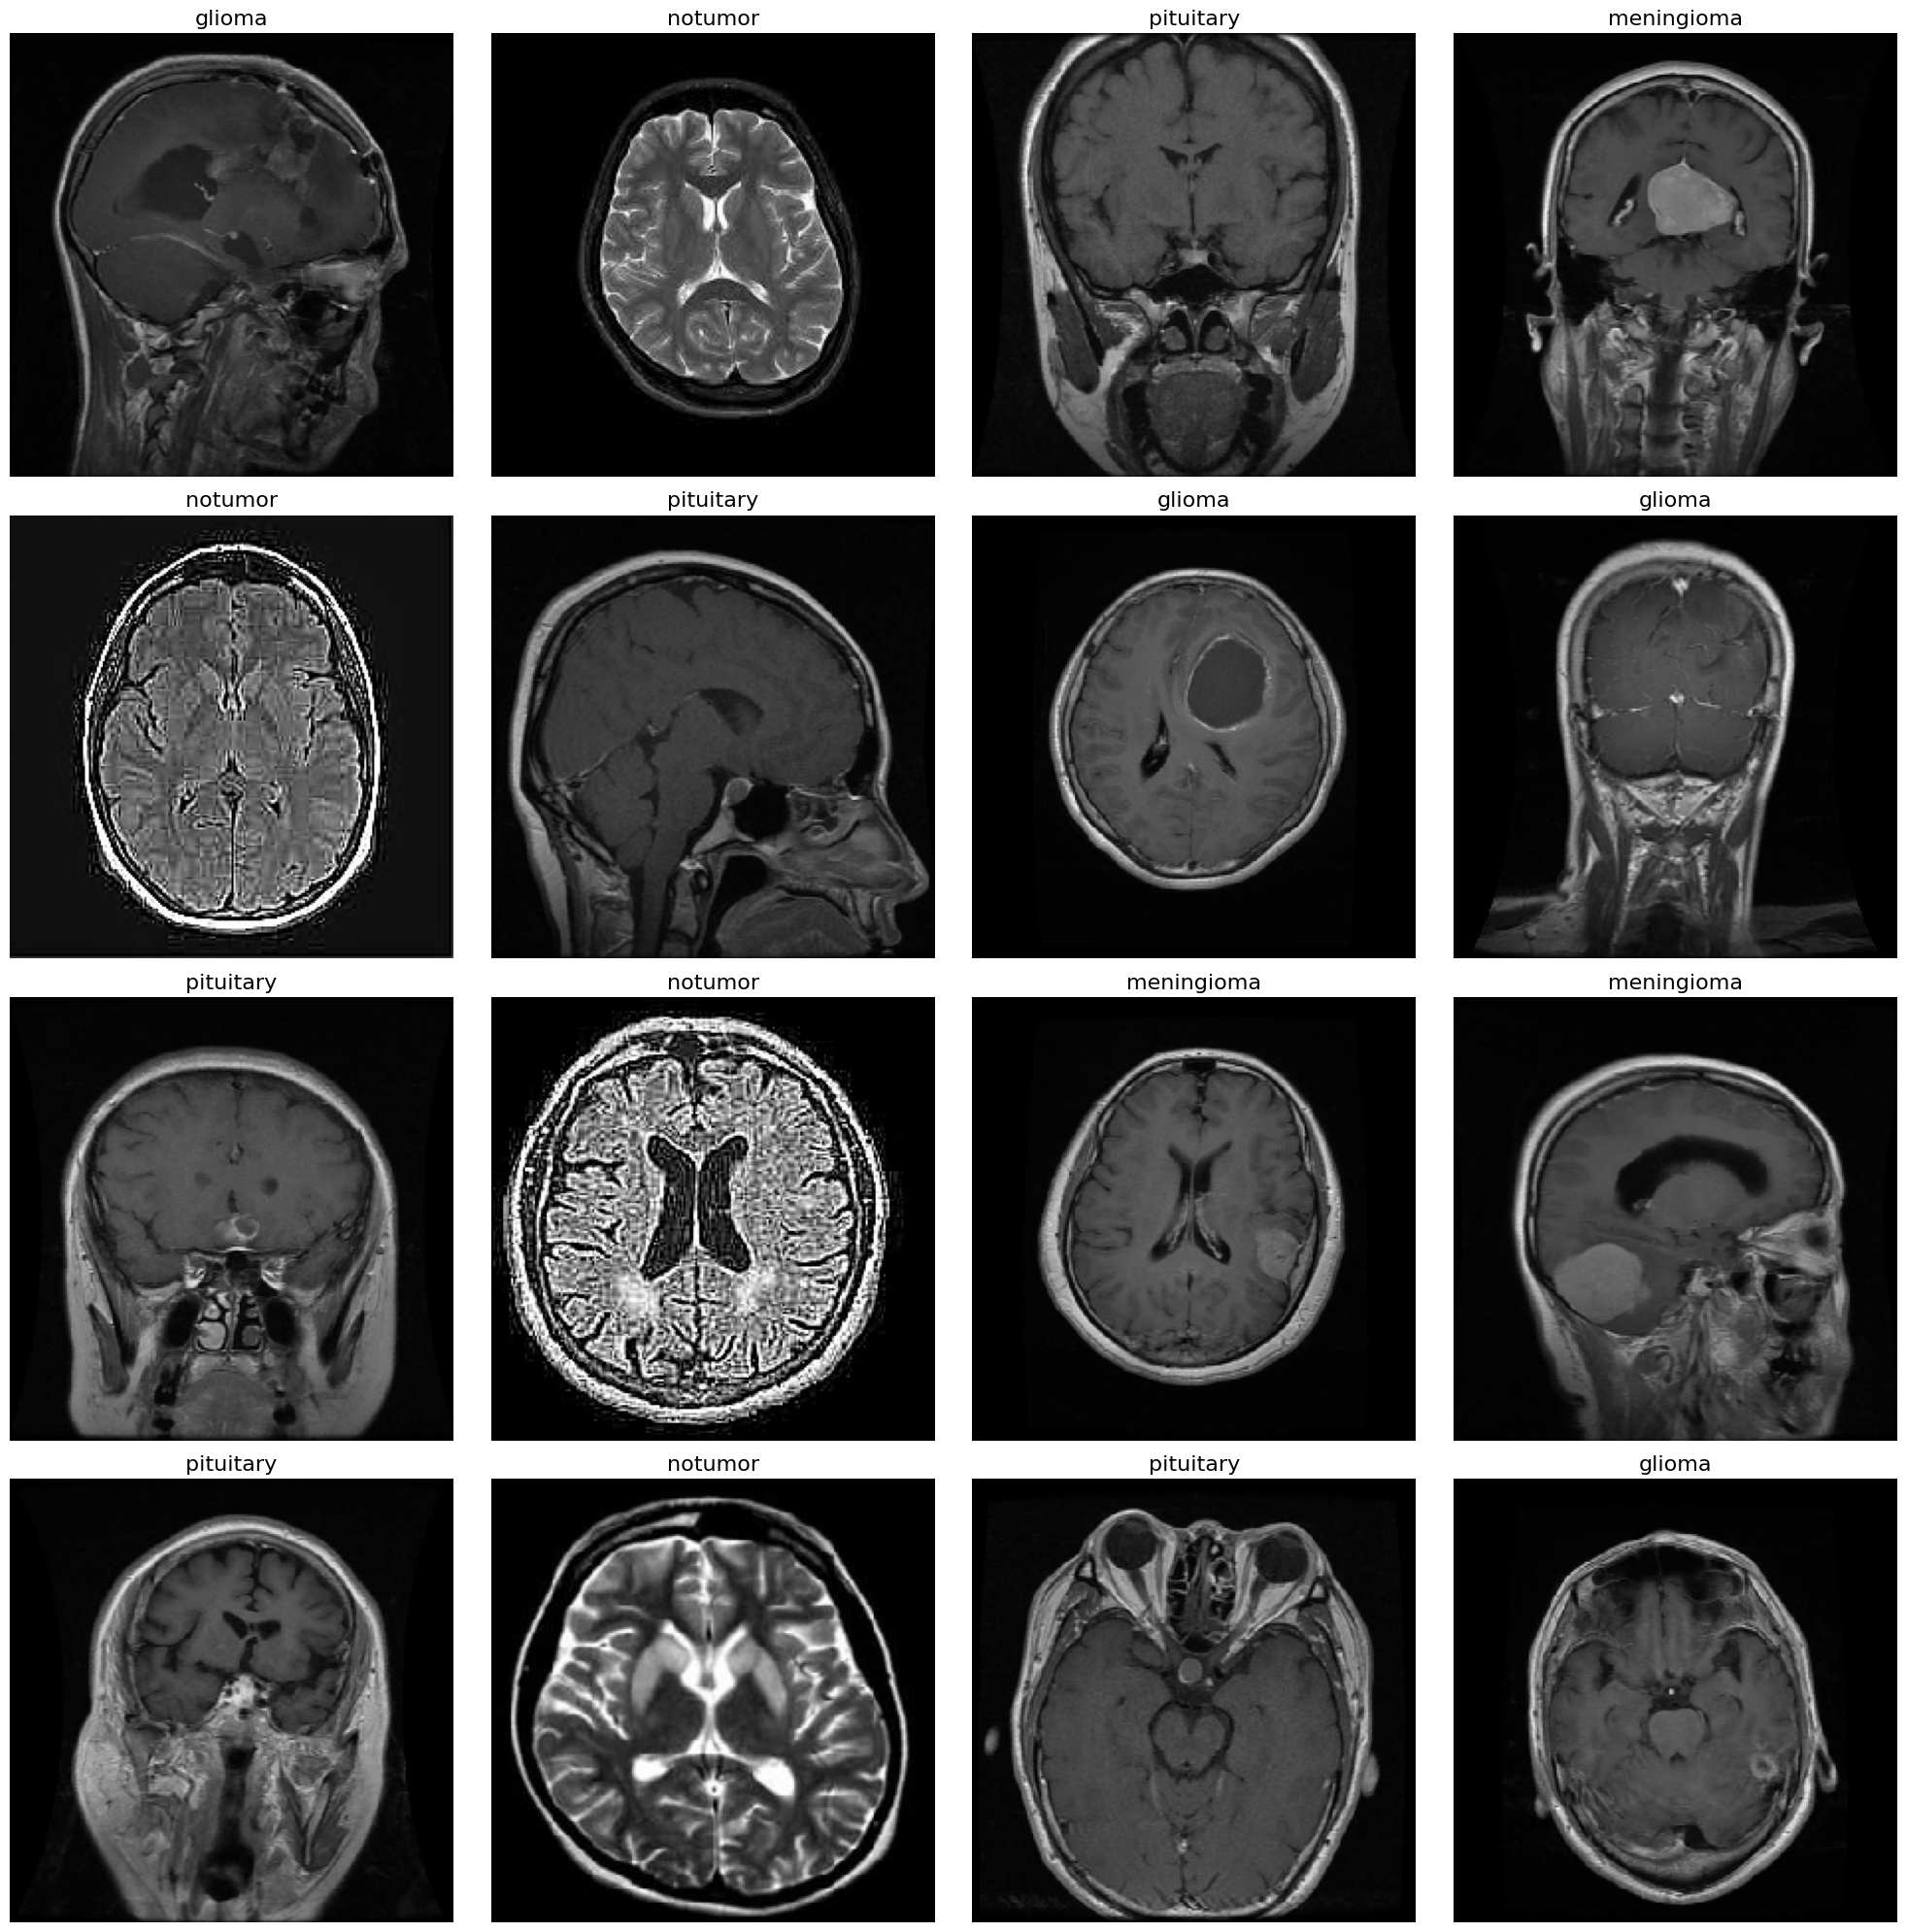

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class CNNHyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential([
            Conv2D(
                filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                padding="same",
                activation="relu",
                input_shape=(224, 224, 3)
            ),
            MaxPooling2D(),
            Conv2D(
                filters=hp.Int('filters_2', min_value=64, max_value=256, step=32),
                kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                padding="same",
                activation="relu"
            ),
            MaxPooling2D(),
            Flatten(),
            Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'),
            Dense(self.num_classes, activation='softmax')
        ])
        model.compile(
            optimizer=Adamax(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
              )
        return model

hypermodel = CNNHyperModel(num_classes=len(train_gen.class_indices))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='CNN_Tuning'
)

tuner.search(train_gen, validation_data=valid_gen, epochs=1, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best hyperparameters:", best_hyperparameters.values)


Trial 2 Complete [00h 37m 33s]
val_accuracy: 0.8931297659873962

Best val_accuracy So Far: 0.8931297659873962
Total elapsed time: 05h 07m 57s
Best hyperparameters: {'filters_1': 96, 'kernel_size_1': 5, 'filters_2': 128, 'kernel_size_2': 3, 'units': 128, 'learning_rate': 0.00013401012750469357}


In [ ]:
# Evaluate best model
train_score = best_model.evaluate(train_gen)
valid_score = best_model.evaluate(valid_gen)
test_score = best_model.evaluate(test_gen)

print("Training Loss:", train_score[0], "Training Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

41/41 [==============================] - 337s 8s/step - loss: 0.5247 - accuracy: 0.8628
Training Loss: 0.24837863445281982 Training Accuracy: 0.930672287940979
Validation Loss: 0.3701625168323517 Validation Accuracy: 0.8931297659873962
Test Loss: 0.5246612429618835 Test Accuracy: 0.8628048896789551


41/41 [==============================] - 66s 2s/step


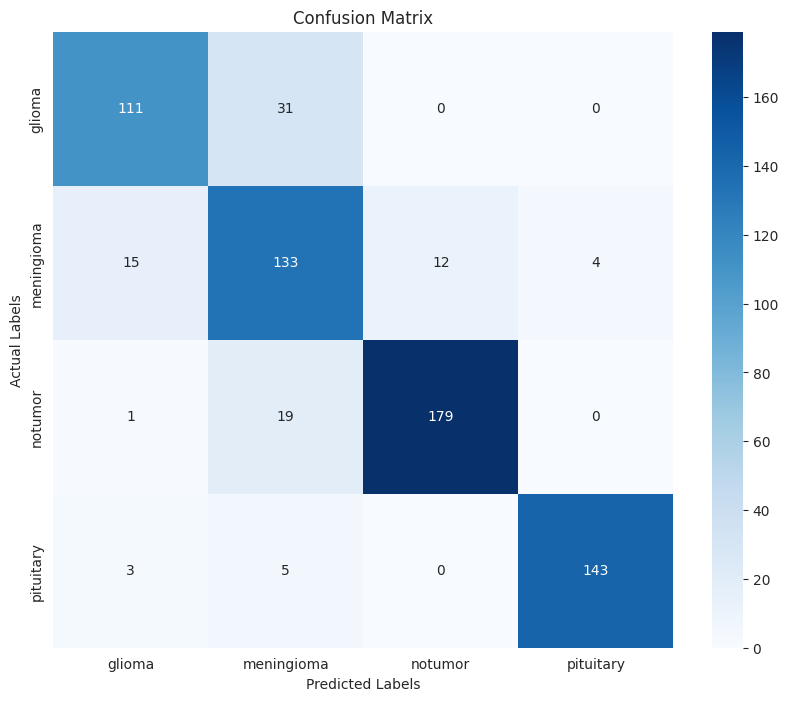

              precision    recall  f1-score   support

      glioma       0.85      0.78      0.82       142
  meningioma       0.71      0.81      0.76       164
     notumor       0.94      0.90      0.92       199
   pituitary       0.97      0.95      0.96       151

    accuracy                           0.86       656
   macro avg       0.87      0.86      0.86       656
weighted avg       0.87      0.86      0.86       656



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions
test_preds = best_model.predict(test_gen)
test_preds_labels = np.argmax(test_preds, axis=1)

# Ensure the generator is reset for consistent indexing
test_gen.reset()

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, test_preds_labels)

# Classification Report
report = classification_report(test_gen.classes, test_preds_labels, target_names=list(test_gen.class_indices.keys()))

# Displaying Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Print the classification report
print(report)
